In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.utils.prune as prune
import networkx as nx
import copy
import circuits as ckt

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': 0.1, 'v': None, 'attr': -2}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': None})]


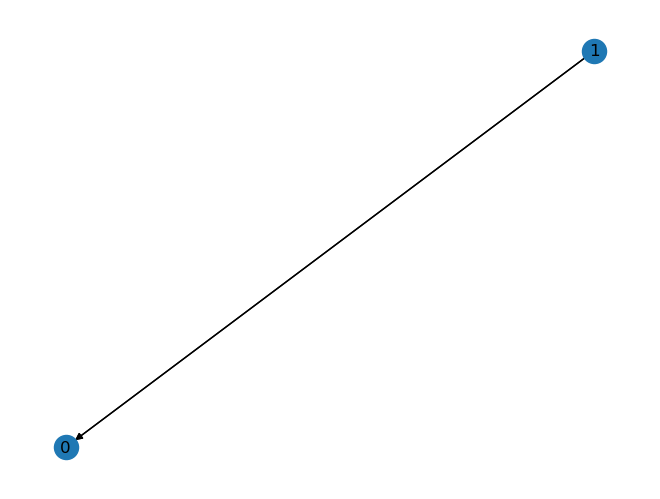

In [3]:
vr = ckt.Circuit()
v_source = vr.add_element(kind=ckt.Kinds.IVS)
resistor = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, resistor.high)
v_source.connect(v_source.low, resistor.low)
v_source.attr = -2
v_source.i = 0.1
# resistor.i = 0.1
print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
# create tensors for voltages, currents, and element attrs
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Extract Circuit Inputs for the Model

In [5]:
input = ckt.Input(vr)

Kinds.IVS
Kinds.R


c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:64: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input.M

tensor([[-1., -1.],
        [ 1.,  1.]])

In [7]:
input.kinds_map

{<Kinds.IVS: 0>: [True, False],
 <Kinds.ICS: 1>: [False, False],
 <Kinds.R: 2>: [False, True]}

In [8]:
input.knowns_map

{<Props.I: 0>: [True, False],
 <Props.V: 1>: [True, False],
 <Props.Attr: 2>: [True, False]}

In [9]:
input.inputs_map

{<Props.I: 0>: [0.1, 0.4054874717700453],
 <Props.V: 1>: [-2.0, 0.9059380952114919],
 <Props.Attr: 2>: [-2.0, 0.6075679437146172]}

In [10]:
input.init_tensors()

(tensor([[0.1000],
         [0.4055]]),
 tensor([[-2.0000],
         [ 0.9059]]),
 tensor([[0.5038],
         [0.9933]]),
 tensor([[-2.0000],
         [ 0.6076]]))

# Define Models

In [11]:
class Solver(nn.Module):
    def __init__(self, input: ckt.Input):
        super().__init__()
        self.input = input
        i_in, v_in, pot_in, attr_in = self.input.init_tensors()
        self.i = nn.Parameter(i_in.clone().detach())
        self.v = nn.Parameter(v_in.clone().detach())
        self.pot = nn.Parameter(pot_in.clone().detach())
        self.attr = nn.Parameter(attr_in.clone().detach())

    def forward(self):
        current_error = self.kcl(input.M, self.i)
        voltage_error = self.kvl(input.M, self.v, self.pot)
        resistor_error = self.resistor(self.i, self.v, self.attr,
                                        self.input.kinds_map[ckt.Kinds.R])
        return current_error, voltage_error, resistor_error

    def kcl(self, M, i):
        current_error = M @ i
        return current_error

    def kvl(self,M,v,pot):
        kvl_error = v - M.T @ pot
        return kvl_error

    def resistor(self,i,v,r,res_mask):
        resistor_v_error = i[res_mask] * r[res_mask] - v[res_mask]
        return resistor_v_error

    def zero_known_grads(self):
        if(self.i.grad != None):
            self.i.grad[self.input.knowns_map[ckt.Props.I]] = 0
        if(self.v.grad != None):
            self.v.grad[self.input.knowns_map[ckt.Props.V]] = 0
        if(self.attr.grad != None):
            self.attr.grad[self.input.knowns_map[ckt.Props.Attr]] = 0

    def zero_res_grads(self):
        if(self.i.grad != None):
            self.i.grad[self.input.kinds_map[ckt.Kinds.R]] = 0
        if(self.v.grad != None):
            self.v.grad[self.input.kinds_map[ckt.Kinds.R]] = 0
        if(self.attr.grad != None):
            self.attr.grad[self.input.kinds_map[ckt.Kinds.R]] = 0

    def freeze_i_v(self):
        self.i.requires_grad = False
        self.v.requires_grad = False

    def unfreeze_i_v(self):
        self.i.requires_grad = True
        self.v.requires_grad = True

    def freeze_attr(self):
        self.attr.requires_grad = False

    def unfreeze_attr(self):
        self.attr.requires_grad = True
    

# Create Instance of Models

In [12]:
model = Solver(input = input).to(device)

# Loss

In [13]:
loss_fn = nn.MSELoss()

# Optimizer

In [14]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.5)

# Train Function

# Using combined losses is better than treating losses separately

In [15]:
def smooth_i():
    #set training mode
    model.train()

    kcl_err, _, _ = model()
    kcl_loss = loss_fn(kcl_err, torch.zeros_like(kcl_err))

    loss = kcl_loss

    model.zero_grad()
    loss.backward()
    model.zero_known_grads()
    optimizer.step()
    
    params = torch.cat(tuple(model.parameters()))

    return loss,params.clone().detach()

In [16]:
def smooth_v():
    #set training mode
    model.train()

    _, kvl_err, _ = model()
    kvl_loss = loss_fn(kvl_err, torch.zeros_like(kvl_err))

    loss = kvl_loss

    model.zero_grad()
    loss.backward()
    model.zero_known_grads()
    # model.zero_res_grads()
    optimizer.step()
    
    params = torch.cat(tuple(model.parameters()))

    return loss,params.clone().detach()

In [18]:
def update_unkown_element_attr():
    #set training mode
    model.train()

    _, _, res_err = model()
    res_loss = loss_fn(res_err, torch.zeros_like(res_err))

    loss = res_loss

    model.zero_grad()
    model.freeze_i_v()
    loss.backward()
    model.zero_known_grads()
    optimizer.step()
    model.unfreeze_i_v()

    params = torch.cat(tuple(model.parameters()))

    return loss,params.clone().detach()

In [19]:
def backprop_i_v_from_element_attr():
    #set training mode
    model.train()

    _, _, res_err = model()
    res_loss = loss_fn(res_err, torch.zeros_like(res_err))

    loss = res_loss

    model.zero_grad()
    loss.backward()
    model.zero_known_grads()
    optimizer.step()

    params = torch.cat(tuple(model.parameters()))

    return loss,params.clone().detach()

In [20]:
def is_stable(prev:torch.Tensor,updated:torch.Tensor, pu_threshold:float):
    abs_val = torch.abs(updated - prev)
    prev_abs = torch.abs(prev)
    pu_change = abs_val / prev_abs
    # print(f' {abs_val} / {prev_abs} = {pu_change}')
    pu_change_max = torch.max(pu_change)
    ret_bool = pu_change_max < pu_threshold
    return ret_bool

In [21]:
epochs = 10000
state = 0
th = 0.000001
prev_loss = 0.1
lt_prev_loss = 1000
loss, params = smooth_i()
print(f'init state {state} loss: {loss.item()}')

prev_params = params

model_is_stable = [False,False,False,False]

# for t in range(epochs):
t = 0
while(False in model_is_stable):

    if(t > epochs):
        break
    else:
        t += 1

    if(state == 0):
        loss,params = smooth_i()
        if(is_stable(prev_params, params, th)):
            state = 1
            model_is_stable[0] = True
    elif(state == 1):
        loss,params = smooth_v()
        if(is_stable(prev_params, params, th)):
            state = 2
            model_is_stable[1] = True
    elif(state == 2):
        loss,params = update_unkown_element_attr()
        if(is_stable(prev_params, params, th)):
            state = 3
            model_is_stable[2] = True
    elif(state == 3):
        # freeze previously updated element attr
        # use element equation as loss function from v->i and i->v
        loss,params = backprop_i_v_from_element_attr()
        if(is_stable(prev_params, params, th)):
            state = 0
            model_is_stable[3] = True
    else:
        assert()

    prev_params = params

    # if (t % (epochs/10)) == 0:
    #     state = ~state
    
    # analyze steps and loss
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

    if (t % (epochs/10)) == 0:
        lt_prev_loss = loss

print(f'Done! at {t} epochs')
print(f"current = {model.i}")
print(f"voltage = {model.v}")
print(f"potential = {model.pot}")
print(f"attributes = {model.attr}")

init state 0 loss: 0.2555176019668579
Done! at 946 epochs
current = Parameter containing:
tensor([[ 0.1000],
        [-0.0384]], requires_grad=True)
voltage = Parameter containing:
tensor([[-2.0000],
        [ 0.1012]], requires_grad=True)
potential = Parameter containing:
tensor([[ 1.6546],
        [-0.3454]], requires_grad=True)
attributes = Parameter containing:
tensor([[-2.0000],
        [-2.6390]], requires_grad=True)


OUTPUT USING GRADIENT FREEZING

1

```python
epoch 0 loss: 3.341080904006958
epoch 1000 loss: 0.0
epoch 2000 loss: 0.0
epoch 3000 loss: 0.0
epoch 4000 loss: 0.0
epoch 5000 loss: 0.0
epoch 6000 loss: 0.0
epoch 7000 loss: 0.0
epoch 8000 loss: 0.0
epoch 9000 loss: 0.0
Done!
current = Parameter containing:
tensor([[-0.5000],
        [ 0.5000]], requires_grad=True)
voltage = Parameter containing:
tensor([[2.],
        [2.]], requires_grad=True)
potential = Parameter containing:
tensor([[-0.7411],
        [ 1.2589]], requires_grad=True)
attributes = Parameter containing:
tensor([[2.],
        [4.]], requires_grad=True)
```

2


```python
epoch 0 loss: 5.810656547546387
epoch 1000 loss: 3.552713678800501e-15
epoch 2000 loss: 3.552713678800501e-15
epoch 3000 loss: 2.7913847588934004e-07
epoch 4000 loss: 1.4210854715202004e-14
epoch 5000 loss: 1.7408297026122455e-11
epoch 6000 loss: 0.0
epoch 7000 loss: 0.0
epoch 8000 loss: 0.0
epoch 9000 loss: 0.0
Done!
params = [('i', Parameter containing:
tensor([[-1.],
        [ 1.]], requires_grad=True)), ('v', Parameter containing:
tensor([[2.],
        [2.]], requires_grad=True)), ('pot', Parameter containing:
tensor([[-0.3692],
        [ 1.6308]], requires_grad=True)), ('attr', Parameter containing:
tensor([[2.],
        [2.]], requires_grad=True))]
```